In [1]:
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import tqdm

In [2]:
default_rng = np.random.default_rng(seed=42)

def d(n : int, gwf : bool = False, rng=default_rng):
  if gwf:
    throw = rng.integers(low=1, high=n, endpoint=True)
    return throw if throw >= 3 else rng.integers(low=1, high=n, endpoint=True)
  else:
    return rng.integers(low=1, high=n, endpoint=True)

def damage(formula, crit : bool = False, gwf : bool = False, rng=default_rng):

  num, die, mod = formula

  if crit:
    return sum(d(die, gwf) for _ in range(2*num)) + mod
  else:
    return sum(d(die, gwf) for _ in range(num)) + mod

def damage_from_atk(die, atk_bonus, armor_class, damage_formula, gwf : bool = True):
  if die==20:
    return damage(damage_formula, gwf=gwf, crit=True)
  elif die==1:
    return 0 
  else:
    if die + atk_bonus > armor_class:
      return damage(damage_formula, gwf)
    else:
      return 0

def total_damage(n_atks, atk_bonus, armor_class, damage_formula, advantage : bool, gwf : bool = True):
  crit = False

  total = 0

  for _ in range(n_atks):
    if advantage:
      die = max(d(20), d(20))
    else:
      die = d(20)
    total += damage_from_atk(die, atk_bonus, armor_class, damage_formula, gwf)

  if crit:
    if advantage:
      die = max(d(20), d(20))
    else:
      die = d(20)
    total += damage_from_atk(die, atk_bonus, armor_class,damage_formula, gwf)

  return total

In [3]:
def simulate(n_atks : int, 
             atk_bonus : int, 
             armor_class : int, 
             damage_formula : tuple, 
             advantage : bool = True, 
             gwf : bool = True, 
             n_smooth : int = 3, 
             n_sim : int = int(1e4)):
  """Simulate `n_atks` attacks from a fighter. 

  Args:
    n_atks (int): number of attacks
    atk_bonus (int): attack bonus
    armor_class (int): AC to hit
    damage_formula (tuple): how to calculate damage, the syntax is (2, 6, 3) for '2d6+3'
    advantage (bool, optional): Whether all the attacks have advantage. Defaults to True.
    gwf (bool, optional): Great Weapon Fighting: reroll 1 and 2 from damage dice. Defaults to True.
    n_smooth (int, optional): Smoothing of the distribution. Defaults to 3.
    n_sim (int, optional): Number of attacks to simulate. Defaults to int(1e4).

  Returns:
    x, y: arrays of ints, representing the probability mass function for the attacks.
  """

  counter = defaultdict(int)
  for _ in tqdm(range(n_sim)):
    counter[total_damage(n_atks, atk_bonus, armor_class, damage_formula, advantage, gwf)] += 1
  
  min_key = min(counter.keys())
  x = np.arange(min_key, max(counter.keys())+1)
  y = np.zeros_like(x)
  for k, v in counter.items():
    y[k-min_key] = v
  
  # smoothing
  y = np.convolve(y, np.ones(n_smooth) / n_smooth, mode='same')
  y /= n_sim

  return x, y

100%|██████████| 1000000/1000000 [00:35<00:00, 28279.67it/s]


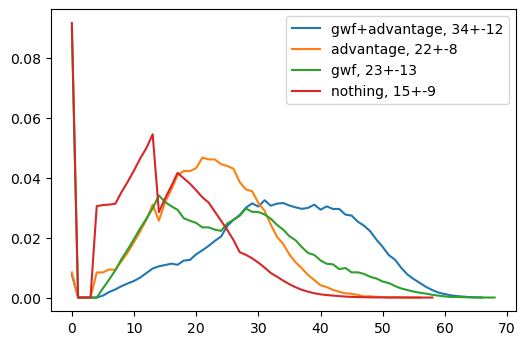

In [4]:
def plot(x, y, label):
  avg = np.average(x, weights=y)
  std = np.sqrt(np.average((x-avg)**2, weights=y))
  label += f', {avg:.0f}+-{std:.0f}'

  plt.plot(x, y, label=label)
n_sim = int(1e5)

plt.figure(dpi=100)
# plot(*simulate(n_atks=8, atk_bonus=6, armor_class=15, damage_formula=(1, 10, 3), advantage=False, gwf=True, n_sim=n_sim), label='calculated')
# plot(*simulate(n_atks=8, atk_bonus=1, armor_class=15, damage_formula=(1, 10, 13), advantage=False, gwf=True, n_sim=n_sim), label='reckless')

plot(*simulate(n_atks=3, atk_bonus=6, armor_class=15, damage_formula=(1, 10, 3), advantage=True, gwf=True, n_smooth=1, n_sim=n_sim), label='gwf+advantage')
plot(*simulate(n_atks=3, atk_bonus=6, armor_class=15, damage_formula=(1, 10, 3), advantage=True, gwf=False, n_smooth=1, n_sim=n_sim), label='advantage')
plot(*simulate(n_atks=3, atk_bonus=6, armor_class=15, damage_formula=(1, 10, 3), advantage=False, gwf=True, n_smooth=1, n_sim=n_sim), label='gwf')
plot(*simulate(n_atks=3, atk_bonus=6, armor_class=15, damage_formula=(1, 10, 3), advantage=False, gwf=False, n_smooth=1, n_sim=n_sim*10), label='nothing')
plt.legend()